In [18]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
from importlib import reload

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.init as init

reload(helper_functions)
from helper_functions import accuracy_rate, load_data, capacity, get_good_idx, get_slice, get_k_fold_cv_idx, get_x_sequences_flattened, train, get_all_accuracy_rates




In [1]:
np.random.seed(2021)

case=1
x,x_time,y,y_time,time_dif,idx_offset = load_data(case)

# Index offset between start and end of training data for one single prediction
# i.e. number of quarters of an hour we wish to train on for each sample
pred_seq_len = 6*4+1


#i=1000
#print(target_time[i])
#print(x_time[i+idx_offset-pred_seq_len+1:i+idx_offset+1])

good_idx = get_good_idx(x,y,idx_offset,pred_seq_len)


print(x.shape)
print(y.shape)
print(x_time[0])
print(y_time[0])
print(len(good_idx))

torch.Size([182918, 16])
torch.Size([147205, 1])
2016-01-01 20:00:00
2017-01-07 20:15:00
137893


In [2]:
input_size = x.shape[1] * pred_seq_len
hidden_size1 = 50
hidden_size2 = 50
out_size = 1


# define network
class Net(nn.Module):

    def __init__(self, input_size, hidden_size1, hidden_size2, out_size):
        super(Net, self).__init__()  
        
        self.model = nn.Sequential(
            nn.Linear(in_features=input_size,
                      out_features=hidden_size1,
                      bias=True),
            nn.ReLU(),
            nn.Linear(in_features=hidden_size1,
                      out_features=hidden_size2,
                      bias=True),
            nn.ReLU(),
            nn.Linear(in_features=hidden_size1,
                      out_features=hidden_size2,
                      bias=True),
            nn.ReLU(),
            nn.Linear(in_features=hidden_size2,
                      out_features=out_size,
                      bias=True)
        )
        
        


    def forward(self, x):
        x = self.model(x)
        return x


net = Net(input_size, hidden_size1, hidden_size2, out_size)
print(net)

Net(
  (model): Sequential(
    (0): Linear(in_features=400, out_features=50, bias=True)
    (1): ReLU()
    (2): Linear(in_features=50, out_features=50, bias=True)
    (3): ReLU()
    (4): Linear(in_features=50, out_features=50, bias=True)
    (5): ReLU()
    (6): Linear(in_features=50, out_features=1, bias=True)
  )
)


In [3]:
# setting hyperparameters and gettings epoch sizes
batch_size = 10000
num_epochs = 10
k_fold_size = 5

loss = nn.MSELoss()
valid_metrics = [nn.MSELoss()]
x_batch = torch.zeros(batch_size, input_size)


train_loss, valid_loss = train(x_batch, x, y, net, num_epochs, batch_size, good_idx, k_fold_size, get_x_sequences_flattened, idx_offset, pred_seq_len, loss, valid_metrics)


Epoch  0 : Training loss: 0.3298, Validation: MSELoss 0.2609
Epoch  1 : Training loss: 0.2319, Validation: MSELoss 0.2122
Epoch  2 : Training loss: 0.2071, Validation: MSELoss 0.2024
Epoch  3 : Training loss: 0.1980, Validation: MSELoss 0.1955
Epoch  4 : Training loss: 0.1931, Validation: MSELoss 0.1919
Epoch  5 : Training loss: 0.1897, Validation: MSELoss 0.1890
Epoch  6 : Training loss: 0.1873, Validation: MSELoss 0.1870
Epoch  7 : Training loss: 0.1854, Validation: MSELoss 0.1856
Epoch  8 : Training loss: 0.1839, Validation: MSELoss 0.1843
Epoch  9 : Training loss: 0.1826, Validation: MSELoss 0.1830


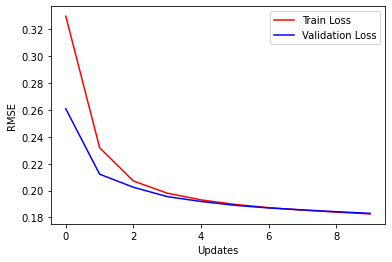

In [4]:
epoch = np.arange(len(train_loss))
plt.figure()
plt.plot(epoch, train_loss, 'r', epoch, valid_loss[0, :], 'b')
plt.legend(['Train Loss','Validation Loss'])
plt.xlabel('Updates'), plt.ylabel('RMSE')
plt.show()

In [5]:
x_batch = torch.zeros(len(good_idx), input_size)
predictions = net(get_x_sequences_flattened(good_idx, x_batch, idx_offset, pred_seq_len, x)).detach().numpy()

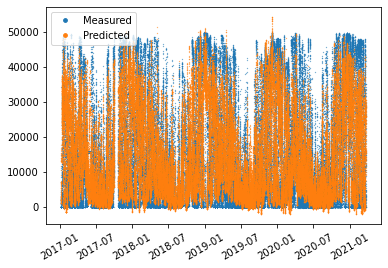

In [6]:
plt.plot(y_time[good_idx], capacity(case)*y[good_idx].detach().numpy(), '.', markersize=0.5, label = 'Measured')
plt.plot(y_time[good_idx], capacity(case)*predictions,'.', markersize=0.5, label = 'Predicted')
lgnd = plt.legend(markerscale=15)    
plt.xticks(rotation=30)
plt.show()

0.8065224302337647


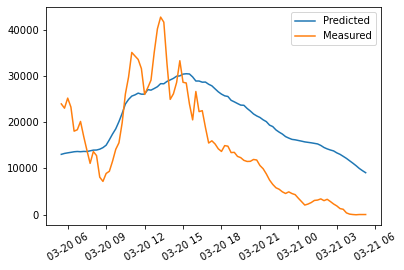

In [7]:
sorted_good = sorted(good_idx)[-96:]
np.all(np.diff(sorted_good)==1)
x_batch = torch.zeros(96, input_size)
get_x_sequences_flattened(sorted_good, x_batch, idx_offset, pred_seq_len, x)
net.eval()
P_P = np.zeros(96)
P_M = np.zeros(96)

P_M = y[sorted_good].detach().numpy() * capacity(case)
P_P = net(x_batch).detach().numpy() * capacity(case)

print(accuracy_rate(P_P, P_M, capacity(case)))


plt.plot(y_time[sorted_good], P_P, label = 'Predicted')
plt.plot(y_time[sorted_good], P_M, label = 'Measured')
plt.legend()
plt.xticks(rotation=30)
plt.show()

In [19]:
x_batch = torch.zeros(96, input_size)
accuracies, times = get_all_accuracy_rates(net, x, y, y_time, x_batch, get_x_sequences_flattened, good_idx, idx_offset, pred_seq_len, case)



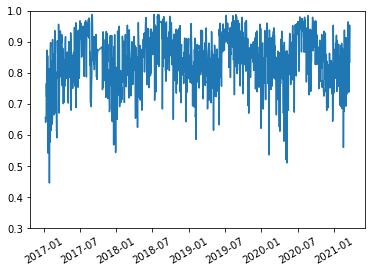

0.8415026103426105


In [21]:
plt.plot(times, accuracies)
plt.xticks(rotation=30)
plt.ylim(0.3,1)
plt.show()
print(np.mean(accuracies))